# Kelly Fomula

Due  August 26th by 10:00 am.

Yuan Yao (s2259521)

## 0. Setup

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('drive/My Drive/Colab Notebooks/dissertation/material')
!ls

In [ ]:
import pandas as pd
import seaborn as sns
import random

# Data libraries
import numpy as np
import scipy
import scipy.stats as stats

# Plotting libraries
import matplotlib.pyplot as plt

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80


## Empirical Study for Single Stock

### 1. Theory

The investment strategy that is discussed here leverages fixed-period bets on the same asset, betting a variable fraction of the portfolio determined by the Kelly Criterion. The Kelly Fraction is defined as
\begin{equation}
f=\frac{\mu-r}{\sigma^2}
\end{equation}
where $r$ is the risk-free rate, $\sigma$ is the standard deviation of returns, and $r$ is the mean return of the asset. In practice we estimate the mean and standard deviation of returns from a sample of historical returns.
\begin{equation}
f_w = \frac{\mu_w - r}{\sigma_w^2}
\end{equation}
and $w$ is the window size, that is the number of timesteps into the past used for the estimation of parameters $\mu_w$ and $\sigma_w$. For example
\begin{equation}
\mu_w = \frac{1}{w} \sum_{i=1}^w return_{today - i}
\end{equation}
You can tune the following parameters:
*   Window size : number of days that you want to look back to calculate the Kelly Factor
*   Rebalancing interval: number of days that you want to wait before rebalancing your portfolio
*   Minimum Kelly Factor: lower bound for the Kelly Factor
*   Maximum Kelly Factor: upper bound for the Kelly Factor
*   Kelly Fraction: Fraction of the Kelly Factor to use for investment into equity

and see how your strategy compares to simply buying and holding the stock.

### 2 Data


1. The return rate on the three-month short term medium term government bond is taken as the risk-free rate. 
Source: https://www.chinabond.com.cn/cb/cn/zzsj/zzjgcp/cpxz/qxxz/zzgzqx/list_2.shtml

In [ ]:
# Get data
total_r = pd.DataFrame()

for i in range(2002,2022):
  res = pd.read_excel(f'./data/{i}.xlsx')
  res = pd.DataFrame(res)
  total_r = pd.concat([total_r, res], axis=0)

# three-month short term medium term government bond
r = total_r[total_r['标准期限说明']=='3m'].reset_index(drop=True)

# data processing of risk-free rate
r = r[['日期','收益率(%)']]
r.columns=['date','annulized return(%)']
r['date'] = pd.to_datetime(r['date'])
r['weekly_rate'] = (1 + r['annulized return(%)']/100) ** (1 / 52)-1
r

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")



2. Select several major indices in the China's A-share market, 分别是沪深300、深圳成指、上证指数、上证50、上证180。

In [ ]:
# pip install tushare
# import tushare as ts
# import os

# mytoken = '81d34e212c4730c307f9b1ec93eb826a160787e06d67f0a848de9b81'
# ts.set_token(mytoken)
# save_path = 'stock'
# pro = ts.pro_api()

In [ ]:
# # 沪深300 
# index = '000300.SH'
# path = os.path.join(save_path, 'OldData', i + '_NormalData.csv')
# df = pro.index_weekly(ts_code=index,
#                       start_date=20050408,
#                       end_date=20211231,
#                       fields='ts_code, trade_date, close')
# df = df.sort_values('trade_date', ascending=True)
# df.to_csv("./data/000300.csv")

# # 深圳成指
# index = '399001.SZ'
# path = os.path.join(save_path, 'OldData', i + '_NormalData.csv')
# df_1 = pro.index_weekly(ts_code=index,
#                       start_date=20020101,
#                       end_date=20101231,
#                       fields='ts_code, trade_date, close')
# df_2 = pro.index_weekly(ts_code=index,
#                       start_date=20110101,
#                       end_date=20211231,
#                       fields='ts_code, trade_date, close')
# df = df_1.append(df_2)
# df = df.sort_values('trade_date', ascending=True)
# df.to_csv("./data/399001.csv")

# # 上证指数
# index = '000001.SH'
# path = os.path.join(save_path, 'OldData', i + '_NormalData.csv')
# df_1 = pro.index_weekly(ts_code=index,
#                       start_date=20020101,
#                       end_date=20101231,
#                       fields='ts_code, trade_date, close')
# df_2 = pro.index_weekly(ts_code=index,
#                       start_date=20110101,
#                       end_date=20211231,
#                       fields='ts_code, trade_date, close')
# df = df_1.append(df_2)
# df = df.sort_values('trade_date', ascending=True)
# df.to_csv("./data/000001.csv")

# # 上证50
# index = '000016.SH'
# path = os.path.join(save_path, 'OldData', i + '_NormalData.csv')
# df = pro.index_weekly(ts_code=index,
#                       start_date=20040102,
#                       end_date=20211231,
#                       fields='ts_code, trade_date, close')
# df = df.sort_values('trade_date', ascending=True)
# df.to_csv("./data/000016.csv")

# # 上证180
# index = '000010.SH'
# path = os.path.join(save_path, 'OldData', i + '_NormalData.csv')
# df_1 = pro.index_weekly(ts_code=index,
#                       start_date=20020101,
#                       end_date=20101231,
#                       fields='ts_code, trade_date, close')
# df_2 = pro.index_weekly(ts_code=index,
#                       start_date=20110101,
#                       end_date=20211231,
#                       fields='ts_code, trade_date, close')
# df = df_1.append(df_2)
# df = df.sort_values('trade_date', ascending=True)
# df.to_csv("./data/000010.csv")

### 2.3 Optimal position estimation and return measurement

1. 沪深300

In [ ]:
index_1 = pd.read_csv('./data/000300.csv',index_col=0)
index_1['trade_date'] = pd.to_datetime(index_1['trade_date'],format = '%Y%m%d')
index_1

,ts_code,trade_date,close
853,000300.SH,2005-04-08,1003.4500
852,000300.SH,2005-04-15,974.0800
851,000300.SH,2005-04-22,939.1000
850,000300.SH,2005-04-29,932.4000
849,000300.SH,2005-05-13,887.5400
...,...,...,...
4,000300.SH,2021-12-03,4901.0175
3,000300.SH,2021-12-10,5055.1172
2,000300.SH,2021-12-17,4954.7599
1,000300.SH,2021-12-24,4921.3449


In [ ]:
index_1['returns'] = index_1['close'] / index_1['close'].shift(1)
index_1['log_returns'] = np.log(index_1['returns'])
index_1_new = index_1.set_index('trade_date').join(r[['weekly_rate','date']].set_index('date'))
index_1_new['excess_rate'] = index_1_new['log_returns'] - index_1_new['weekly_rate']
index_1_new

,ts_code,close,returns,log_returns,weekly_rate,excess_rate
trade_date,,,,,,
2005-04-08,000300.SH,1003.4500,NaN,NaN,0.000471,NaN
2005-04-15,000300.SH,974.0800,0.970731,-0.029706,0.000444,-0.030150
2005-04-22,000300.SH,939.1000,0.964089,-0.036571,0.000428,-0.037000
2005-04-29,000300.SH,932.4000,0.992866,-0.007160,0.000467,-0.007627
2005-05-13,000300.SH,887.5400,0.951888,-0.049308,0.000453,-0.049762
...,...,...,...,...,...,...
2021-12-03,000300.SH,4901.0175,1.008414,0.008378,0.000434,0.007944
2021-12-10,000300.SH,5055.1172,1.031442,0.030958,0.000441,0.030517
2021-12-17,000300.SH,4954.7599,0.980147,-0.020052,0.000443,-0.020496


In [ ]:
mean = index_1_new['excess_rate'].mean()
std = index_1_new['excess_rate'].std()
f = mean / (std**2+mean**2)
print(f'Mean is {mean}.')
print(f'Standard deviation is {std}.')
print(f'The Kelly fraction is {f}')

Mean is 0.0014130209877075692.
Standard deviation is 0.03626365802378856.
The Kelly fraction is 1.072868532699209


In [ ]:
wealth_0 = 100.0
index_1_new['wealth'] = wealth_0
for i in range(1,len(index_1_new)):
  index_1_new['wealth'][i] = index_1_new['wealth'][i-1]*(f*np.exp(index_1_new['log_returns'][i])+(1-f)*np.exp(index_1_new['weekly_rate'][i]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
weeks = len(index_1_new)
hold_return = np.log((index_1_new['close'][weeks-1]/index_1_new['close'][0])**(1/weeks))
kelly_return = np.log((index_1_new['wealth'][weeks-1]/wealth_0)**(1/weeks))
print(f'The geometric average rate of return under buy-and-hold strategy is {hold_return}.')
print(f'The geometric average rate of return under Kelly strategy is {kelly_return}.')

The geometric average rate of return under buy-and-hold strategy is 0.0018665068299107725.
The geometric average rate of return under Kelly strategy is 0.0019178098676913774.


In [ ]:
index_1 = pd.read_csv('./data/000300.csv',index_col=0)
index_1['trade_date'] = pd.to_datetime(index_1['trade_date'],format = '%Y%m%d')
index_1['returns'] = index_1['close'] / index_1['close'].shift(1)
# index_1['log_returns'] = np.log(index_1['returns'])
index_1_new = index_1.set_index('trade_date').join(r[['weekly_rate','date']].set_index('date'))
index_1_new['weekly_rate'].fillna(index_1_new['weekly_rate'].interpolate(), inplace=True)
index_1_new['excess_rate'] = index_1_new['returns'] - 1 - index_1_new['weekly_rate']

mean = index_1_new['excess_rate'].mean()
std = index_1_new['excess_rate'].std()
f = mean / (std**2+mean**2)
print(f'Mean is {mean}.')
print(f'Standard deviation is {std}.')
print(f'The Kelly fraction is {f}')

wealth_0 = 100.0
index_1_new['wealth'] = wealth_0
for i in range(1,len(index_1_new)):
  index_1_new['wealth'][i] = index_1_new['wealth'][i-1]*(f*index_1_new['returns'][i]+(1-f)*(1+index_1_new['weekly_rate'][i]))

weeks = len(index_1_new)
hold_return = np.log((index_1_new['close'][weeks-1]/index_1_new['close'][0])**(1/weeks))
kelly_return = np.log((index_1_new['wealth'][weeks-1]/wealth_0)**(1/weeks))
print(f'The geometric average rate of return under buy-and-hold strategy is {hold_return}.')
print(f'The geometric average rate of return under Kelly strategy is {kelly_return}.')

Mean is 0.0020701728003492546.
Standard deviation is 0.036193208727613564.
The Kelly fraction is 1.5751934908180287


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The geometric average rate of return under buy-and-hold strategy is 0.0018665068299107725.
The geometric average rate of return under Kelly strategy is 0.002077924418238679.


In [ ]:
# fractions = []
for f in np.linspace(1.075,1.975,10):
  # fraction = 'fraction={:.3f}'.format(f)
  # fractions.append(fraction)
  index_1_new['fraction={:.3f}'.format(f)] = wealth_0
  for i in range(1,len(index_1_new)):
    index_1_new['fraction={:.3f}'.format(f)][i] = index_1_new['fraction={:.3f}'.format(f)][i-1]*(f*index_1_new['returns'][i]+(1-f)*(1+index_1_new['weekly_rate'][i]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
index_1_new.iloc[853]

ts_code            000300.SH
close              4940.3733
returns             1.003867
weekly_rate         0.000381
excess_rate         0.003486
wealth            589.761159
fraction=1.075    515.005628
fraction=1.175    541.441817
fraction=1.275    562.770744
fraction=1.375    578.267883
fraction=1.475    587.381233
fraction=1.575    589.763191
fraction=1.675    585.291897
fraction=1.775    574.080301
fraction=1.875    556.472069
fraction=1.975     533.02447
Name: 2021-12-31 00:00:00, dtype: object

In [ ]:
for f in np.linspace(1.075,1.975,10):
  print(np.log((index_1_new['fraction={:.3f}'.format(f)][853]/wealth_0)**(1/853)))

0.0019214626530052433
0.001980147041068438
0.0020254421515501723
0.0020572884408012722
0.0020756200276982025
0.0020803644779026757
0.002071442563126846
0.0020487679932338874
0.002012247118673166
0.001961778600395783


In [ ]:
total_return = []
avg_log_return = []
fraction = np.linspace(0,3,601)
for f in fraction = np.linspace(0,3,601):
  wealth = []
  wealth.append(wealth_0)
  for i in range(1,len(index_1_new)):
    wealth.append(wealth[i-1]*(f*index_1_new['returns'][i]+(1-f)*(1+index_1_new['weekly_rate'][i])))
  total_return.append(wealth[-1]/wealth_0)
  avg_log_return.append(np.log((wealth[-1]/wealth_0)**(1/len(index_1_new))))

In [ ]:
from matplotlib.ticker import FuncFormatter

In [ ]:
plt.figure(dpi=600)

<Figure size 4800x3000 with 0 Axes>

<Figure size 4800x3000 with 0 Axes>

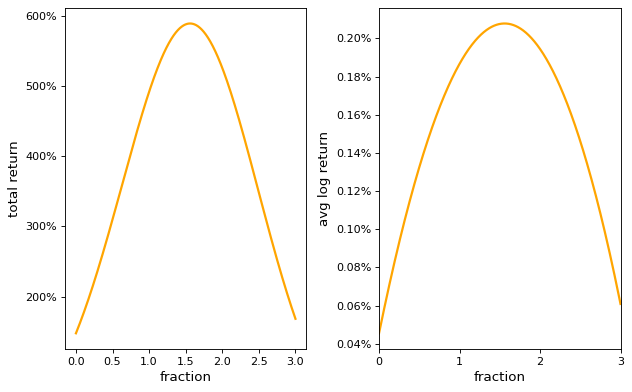

In [ ]:
ax1 = plt.subplot(1,2,1)
plt.sca(ax1)              #选择ax1
plt.plot(fraction,total_return,linewidth=2,color='orange')
def to_percent(temp, position):
  return '%1.0f'%(100*temp) + '%'
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
# plt.gca().xaxis.set_major_formatter(FuncFormatter(to_percent))
plt.xlabel('fraction', fontsize = 12)
plt.ylabel('total return', fontsize = 12)
 
ax2 = plt.subplot(1,2,2)
plt.sca(ax2)              #选择ax2
plt.plot(fraction,avg_log_return,linewidth=2,color='orange')
x=range(0,20,1)
plt.xticks(x)
def to_percent(temp, position):
  return '%1.2f'%(100*temp) + '%'
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
plt.xlim(0, 3)
plt.xlabel('fraction', fontsize = 12)
plt.ylabel('avg log return', fontsize = 12)
# plt.savefig('FFT3',bbox_inches = 'tight',pad_inches = 0,dpi =350）
plt.tight_layout()

2. 深圳成指

In [ ]:
index_2 = pd.read_csv('./data/399001.csv',index_col=0)
index_2['trade_date'] = pd.to_datetime(index_2['trade_date'],format = '%Y%m%d')
index_2['returns'] = index_2['close'] / index_2['close'].shift(1)
index_2['log_returns'] = np.log(index_2['returns'])
index_2_new = index_2.set_index('trade_date').join(r[['weekly_rate','date']].set_index('date'))
index_2_new['weekly_rate'].fillna(index_2_new['weekly_rate'].interpolate(), inplace=True)
index_2_new['excess_rate'] = index_2_new['log_returns'] - index_2_new['weekly_rate']

mean = index_2_new['excess_rate'].mean()
std = index_2_new['excess_rate'].std()
f = mean / (std**2+mean**2)
print(f'Mean is {mean}.')
print(f'Standard deviation is {std}.')
print(f'The Kelly fraction is {f}')

wealth_0 = 100.0
index_2_new['wealth'] = wealth_0
for i in range(1,len(index_2_new)):
  index_2_new['wealth'][i] = index_2_new['wealth'][i-1]*(f*np.exp(index_2_new['log_returns'][i])+(1-f)*np.exp(index_2_new['weekly_rate'][i]))

weeks = len(index_2_new)
hold_return = np.log((index_2_new['close'][weeks-1]/index_2_new['close'][0])**(1/weeks))
kelly_return = np.log((index_2_new['wealth'][weeks-1]/wealth_0)**(1/weeks))
print(f'The geometric average rate of return under buy-and-hold strategy is {hold_return}.')
print(f'The geometric average rate of return under Kelly strategy is {kelly_return}.')

Mean is 0.0010422206941384528.
Standard deviation is 0.038203874438475116.
The Kelly fraction is 0.7135456802271948


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The geometric average rate of return under buy-and-hold strategy is 0.0014911082900301586.
The geometric average rate of return under Kelly strategy is 0.0013420243149000854.


In [ ]:
index_2 = pd.read_csv('./data/399001.csv',index_col=0)
index_2['trade_date'] = pd.to_datetime(index_2['trade_date'],format = '%Y%m%d')
index_2['returns'] = index_2['close'] / index_2['close'].shift(1)
# index_2['log_returns'] = np.log(index_2['returns'])
index_2_new = index_2.set_index('trade_date').join(r[['weekly_rate','date']].set_index('date'))
index_2_new['weekly_rate'].fillna(index_2_new['weekly_rate'].interpolate(), inplace=True)
index_2_new['excess_rate'] = index_2_new['returns'] - 1 - index_2_new['weekly_rate']

mean = index_2_new['excess_rate'].mean()
std = index_2_new['excess_rate'].std()
f = mean / (std**2+mean**2)
print(f'Mean is {mean}.')
print(f'Standard deviation is {std}.')
print(f'The Kelly fraction is {f}')

wealth_0 = 100.0
index_2_new['wealth'] = wealth_0
for i in range(1,len(index_2_new)):
  index_2_new['wealth'][i] = index_2_new['wealth'][i-1]*(f*index_2_new['returns'][i]+(1-f)*(1+index_2_new['weekly_rate'][i]))

weeks = len(index_2_new)
hold_return = np.log((index_2_new['close'][weeks-1]/index_2_new['close'][0])**(1/weeks))
kelly_return = np.log((index_2_new['wealth'][weeks-1]/wealth_0)**(1/weeks))
print(f'The geometric average rate of return under buy-and-hold strategy is {hold_return}.')
print(f'The geometric average rate of return under Kelly strategy is {kelly_return}.')

Mean is 0.0017702259343083712.
Standard deviation is 0.038086025444797895.
The Kelly fraction is 1.217755703188677


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The geometric average rate of return under buy-and-hold strategy is 0.0014911082900301586.
The geometric average rate of return under Kelly strategy is 0.0015233280341068573.


3. 上证指数

In [ ]:
index_3 = pd.read_csv('./data/000001.csv',index_col=0)
index_3['trade_date'] = pd.to_datetime(index_3['trade_date'],format = '%Y%m%d')
index_3['returns'] = index_3['close'] / index_3['close'].shift(1)
index_3['log_returns'] = np.log(index_3['returns'])
index_3_new = index_3.set_index('trade_date').join(r[['weekly_rate','date']].set_index('date'))
index_3_new['weekly_rate'].fillna(index_3_new['weekly_rate'].interpolate(), inplace=True)
index_3_new['excess_rate'] = index_3_new['log_returns'] - index_3_new['weekly_rate']

mean = index_3_new['excess_rate'].mean()
std = index_3_new['excess_rate'].std()
f = mean / (std**2+mean**2)
print(f'Mean is {mean}.')
print(f'Standard deviation is {std}.')
print(f'The Kelly fraction is {f}')

wealth_0 = 100.0
index_3_new['wealth'] = wealth_0
for i in range(1,len(index_3_new)):
  index_3_new['wealth'][i] = index_3_new['wealth'][i-1]*(f*np.exp(index_3_new['log_returns'][i])+(1-f)*np.exp(index_3_new['weekly_rate'][i]))

weeks = len(index_3_new)
hold_return = np.log((index_3_new['close'][weeks-1]/index_3_new['close'][0])**(1/weeks))
kelly_return = np.log((index_3_new['wealth'][weeks-1]/wealth_0)**(1/weeks))
print(f'The geometric average rate of return under buy-and-hold strategy is {hold_return}.')
print(f'The geometric average rate of return under Kelly strategy is {kelly_return}.')

Mean is 0.0003524245675124625.
Standard deviation is 0.0328040221766701.
The Kelly fraction is 0.32746271539679206


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The geometric average rate of return under buy-and-hold strategy is 0.0008019910965997532.
The geometric average rate of return under Kelly strategy is 0.0006833771738010498.


In [ ]:
index_3 = pd.read_csv('./data/000001.csv',index_col=0)
index_3['trade_date'] = pd.to_datetime(index_3['trade_date'],format = '%Y%m%d')
index_3['returns'] = index_3['close'] / index_3['close'].shift(1)
# index_3['log_returns'] = np.log(index_3['returns'])
index_3_new = index_3.set_index('trade_date').join(r[['weekly_rate','date']].set_index('date'))
index_3_new['weekly_rate'].fillna(index_3_new['weekly_rate'].interpolate(), inplace=True)
index_3_new['excess_rate'] = index_3_new['returns'] - 1 - index_3_new['weekly_rate']

mean = index_3_new['excess_rate'].mean()
std = index_3_new['excess_rate'].std()
f = mean / (std**2+mean**2)
print(f'Mean is {mean}.')
print(f'Standard deviation is {std}.')
print(f'The Kelly fraction is {f}')

wealth_0 = 100.0
index_3_new['wealth'] = wealth_0
for i in range(1,len(index_3_new)):
  index_3_new['wealth'][i] = index_3_new['wealth'][i-1]*(f*index_3_new['returns'][i]+(1-f)*(1+index_3_new['weekly_rate'][i]))

weeks = len(index_3_new)
hold_return = np.log((index_3_new['close'][weeks-1]/index_3_new['close'][0])**(1/weeks))
kelly_return = np.log((index_3_new['wealth'][weeks-1]/wealth_0)**(1/weeks))
print(f'The geometric average rate of return under buy-and-hold strategy is {hold_return}.')
print(f'The geometric average rate of return under Kelly strategy is {kelly_return}.')

Mean is 0.0008892316479405468.
Standard deviation is 0.03276011790632019.
The Kelly fraction is 0.827950048963163


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The geometric average rate of return under buy-and-hold strategy is 0.0008019910965997532.
The geometric average rate of return under Kelly strategy is 0.0008180111404513507.


4. 上证50

In [ ]:
index_4 = pd.read_csv('./data/000016.csv',index_col=0)
index_4['trade_date'] = pd.to_datetime(index_4['trade_date'],format = '%Y%m%d')
index_4['returns'] = index_4['close'] / index_4['close'].shift(1)
index_4['log_returns'] = np.log(index_4['returns'])
index_4_new = index_4.set_index('trade_date').join(r[['weekly_rate','date']].set_index('date'))
index_4_new['weekly_rate'].fillna(index_4_new['weekly_rate'].interpolate(), inplace=True)
index_4_new['excess_rate'] = index_4_new['log_returns'] - index_4_new['weekly_rate']

mean = index_4_new['excess_rate'].mean()
std = index_4_new['excess_rate'].std()
f = mean / (std**2+mean**2)
print(f'Mean is {mean}.')
print(f'Standard deviation is {std}.')
print(f'The Kelly fraction is {f}')

wealth_0 = 100.0
index_4_new['wealth'] = wealth_0
for i in range(1,len(index_4_new)):
  index_4_new['wealth'][i] = index_4_new['wealth'][i-1]*(f*np.exp(index_4_new['log_returns'][i])+(1-f)*np.exp(index_4_new['weekly_rate'][i]))

weeks = len(index_4_new)
hold_return = np.log((index_4_new['close'][weeks-1]/index_4_new['close'][0])**(1/weeks))
kelly_return = np.log((index_4_new['wealth'][weeks-1]/wealth_0)**(1/weeks))
print(f'The geometric average rate of return under buy-and-hold strategy is {hold_return}.')
print(f'The geometric average rate of return under Kelly strategy is {kelly_return}.')

Mean is 0.0008240041429841846.
Standard deviation is 0.036179915920676715.
The Kelly fraction is 0.6291715476501166


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The geometric average rate of return under buy-and-hold strategy is 0.0012811639946851815.
The geometric average rate of return under Kelly strategy is 0.001128315513566259.


In [ ]:
index_4_new

,ts_code,close,returns,log_returns,weekly_rate,excess_rate,wealth
trade_date,,,,,,,
2004-01-02,000016.SH,1011.3470,NaN,NaN,0.000349,NaN,100.000000
2004-01-09,000016.SH,1081.7850,1.069648,0.067329,0.000587,0.066743,104.403796
2004-01-16,000016.SH,1083.6520,1.001726,0.001724,0.000446,0.001278,104.534450
2004-01-30,000016.SH,1067.5530,0.985144,-0.014968,0.000421,-0.015388,103.573667
2004-02-06,000016.SH,1122.0840,1.051080,0.049819,0.000376,0.049443,106.916775
...,...,...,...,...,...,...,...
2021-12-03,000016.SH,3221.4223,1.010687,0.010631,0.000434,0.010196,278.301378
2021-12-10,000016.SH,3353.6302,1.041040,0.040220,0.000441,0.039779,285.533023
2021-12-17,000016.SH,3278.8985,0.977716,-0.022536,0.000443,-0.022979,281.576703


In [ ]:
index_4 = pd.read_csv('./data/000016.csv',index_col=0)
index_4['trade_date'] = pd.to_datetime(index_4['trade_date'],format = '%Y%m%d')
index_4['returns'] = index_4['close'] / index_4['close'].shift(1)
index_4_new = index_4.set_index('trade_date').join(r[['weekly_rate','date']].set_index('date'))
index_4_new['weekly_rate'].fillna(index_4_new['weekly_rate'].interpolate(), inplace=True)
index_4_new['excess_rate'] = index_4_new['returns'] - 1 - index_4_new['weekly_rate']

mean = index_4_new['excess_rate'].mean()
std = index_4_new['excess_rate'].std()
f = mean / (std**2+mean**2)
print(f'Mean is {mean}.')
print(f'Standard deviation is {std}.')
print(f'The Kelly fraction is {f}')

wealth_0 = 100.0
index_4_new['wealth'] = wealth_0
for i in range(1,len(index_4_new)):
  index_4_new['wealth'][i] = index_4_new['wealth'][i-1]*(f*index_4_new['returns'][i]+(1-f)*(1+index_4_new['weekly_rate'][i]))

weeks = len(index_4_new)
hold_return = np.log((index_4_new['close'][weeks-1]/index_4_new['close'][0])**(1/weeks))
kelly_return = np.log((index_4_new['wealth'][weeks-1]/wealth_0)**(1/weeks))
print(f'The geometric average rate of return under buy-and-hold strategy is {hold_return}.')
print(f'The geometric average rate of return under Kelly strategy is {kelly_return}.')

Mean is 0.001479406567283047.
Standard deviation is 0.036292515470347515.
The Kelly fraction is 1.1213271876686974


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The geometric average rate of return under buy-and-hold strategy is 0.0012811639946851815.
The geometric average rate of return under Kelly strategy is 0.0012921366650069654.


5. 上证180

In [ ]:
index_5 = pd.read_csv('./data/000010.csv',index_col=0)
index_5['trade_date'] = pd.to_datetime(index_5['trade_date'],format = '%Y%m%d')
index_5['returns'] = index_5['close'] / index_5['close'].shift(1)
index_5['log_returns'] = np.log(index_5['returns'])
index_5_new = index_5.set_index('trade_date').join(r[['weekly_rate','date']].set_index('date'))
index_5_new['weekly_rate'].fillna(index_5_new['weekly_rate'].interpolate(), inplace=True)
index_5_new['excess_rate'] = index_5_new['log_returns'] - index_5_new['weekly_rate']

mean = index_5_new['excess_rate'].mean()
std = index_5_new['excess_rate'].std()
f = mean / (std**2+mean**2)
print(f'Mean is {mean}.')
print(f'Standard deviation is {std}.')
print(f'The Kelly fraction is {f}')

wealth_0 = 100.0
index_5_new['wealth'] = wealth_0
for i in range(1,len(index_5_new)):
  index_5_new['wealth'][i] = index_5_new['wealth'][i-1]*(f*np.exp(index_5_new['log_returns'][i])+(1-f)*np.exp(index_5_new['weekly_rate'][i]))

weeks = len(index_5_new)
hold_return = np.log((index_5_new['close'][weeks-1]/index_5_new['close'][0])**(1/weeks))
kelly_return = np.log((index_5_new['wealth'][weeks-1]/wealth_0)**(1/weeks))
print(f'The geometric average rate of return under buy-and-hold strategy is {hold_return}.')
print(f'The geometric average rate of return under Kelly strategy is {kelly_return}.')

Mean is 0.0007430458563208335.
Standard deviation is 0.034974532133504266.
The Kelly fraction is 0.6071776944615118


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The geometric average rate of return under buy-and-hold strategy is 0.0011922279156355731.
The geometric average rate of return under Kelly strategy is 0.0010462714800311941.


In [ ]:
index_5 = pd.read_csv('./data/000010.csv',index_col=0)
index_5['trade_date'] = pd.to_datetime(index_5['trade_date'],format = '%Y%m%d')
index_5['returns'] = index_5['close'] / index_5['close'].shift(1)
index_5_new = index_5.set_index('trade_date').join(r[['weekly_rate','date']].set_index('date'))
index_5_new['weekly_rate'].fillna(index_5_new['weekly_rate'].interpolate(), inplace=True)
index_5_new['excess_rate'] = index_5_new['returns'] - 1 - index_5_new['weekly_rate']

mean = index_5_new['excess_rate'].mean()
std = index_5_new['excess_rate'].std()
f = mean / (std**2+mean**2)
print(f'Mean is {mean}.')
print(f'Standard deviation is {std}.')
print(f'The Kelly fraction is {f}')

wealth_0 = 100.0
index_5_new['wealth'] = wealth_0
for i in range(1,len(index_5_new)):
  index_5_new['wealth'][i] = index_5_new['wealth'][i-1]*(f*index_5_new['returns'][i]+(1-f)*(1+index_5_new['weekly_rate'][i]))

weeks = len(index_5_new)
hold_return = np.log((index_5_new['close'][weeks-1]/index_5_new['close'][0])**(1/weeks))
kelly_return = np.log((index_5_new['wealth'][weeks-1]/wealth_0)**(1/weeks))
print(f'The geometric average rate of return under buy-and-hold strategy is {hold_return}.')
print(f'The geometric average rate of return under Kelly strategy is {kelly_return}.')

Mean is 0.0013545729562677354.
Standard deviation is 0.03500394006916906.
The Kelly fraction is 1.1038718586899925


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The geometric average rate of return under buy-and-hold strategy is 0.0011922279156355731.
The geometric average rate of return under Kelly strategy is 0.0011992014082136877.
